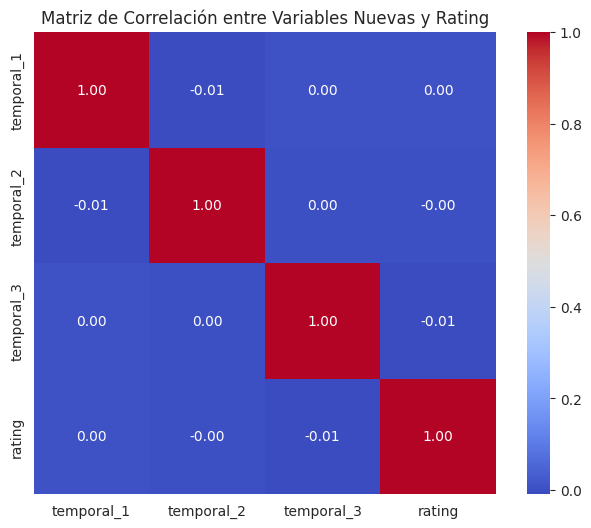


📊 Correlación de Variables con Rating:

temporal_1    0.003952
temporal_2   -0.000438
temporal_3   -0.009007
Name: rating, dtype: float64


In [10]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 1. Cargar tu dataset limpio (el que tiene temporal_1, temporal_2, temporal_3, etc.)
df = pd.read_csv("dataset_final.csv")

# 🔹 2. Seleccionar las columnas que quieres analizar
features = ['temporal_1', 'temporal_2', 'temporal_3']  # puedes agregar más si tienes
features.append('rating')  # agregamos el rating para la correlación

# 🔹 3. Calcular la matriz de correlación
correlation_matrix = df[features].corr()

# 🔹 4. Visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación entre Variables Nuevas y Rating")
plt.show()

correlation_with_rating = correlation_matrix['rating'].drop('rating').sort_values(ascending=False)

print("\n📊 Correlación de Variables con Rating:\n")
print(correlation_with_rating)


In [11]:

import pandas as pd
import numpy as np
from fastFM import sgd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import sparse

df = pd.read_csv("dataset_final.csv")

X = df[['temporal_1', 'temporal_2', 'temporal_3']]
y = df['rating']

# 🔹 3. Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a sparse matrix (porque fastFM necesita sparse)
X_sparse = sparse.csr_matrix(X_scaled)

# 🔹 4. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# 🔹 5. Crear el modelo Factorization Machine
fm = sgd.FMRegression(n_iter=1000, init_stdev=0.1, l2_reg_w=0.1, l2_reg_V=0.5, rank=8, random_state=42)

# 🔹 6. Entrenar el modelo
fm.fit(X_train, y_train)

# 🔹 7. Predecir
y_pred = fm.predict(X_test)

# 🔹 8. Evaluar con RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n🔍 RMSE obtenido en test: {rmse:.4f}")




🔍 RMSE obtenido en test: 1.2839


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 🔹 1. Cargar el dataset final con features y UMAP
df = pd.read_csv("dataset_final.csv")

# 🔹 2. Definir features y target
features = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating_previous', 'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario', 'antiguedad_rating', 'diferencia_rating_anterior'
]

X = df[features]
y = df['rating']

# 🔹 3. Partir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Mostrar las primeras filas del dataframe final antes de entrenar
print(df[features].head(100))  # Muestra 10 ejemplos


    userId  movieId  temporal_1  temporal_2  temporal_3  rating_previous  \
0        1      541    4.648886   11.704415    3.590085              0.0   
1        1      166   13.267731   12.017683    2.657761              5.0   
2        1     1784   13.267747   12.017708    2.657773              5.0   
3        1     1944    2.503541   19.755627   13.301084              1.0   
4        1     1208   -5.758954   -2.535245   14.551048              2.0   
..     ...      ...         ...         ...         ...              ...   
95      10     2700    2.566845    3.896240    0.231980              2.0   
96      10     5349   -1.192748   15.284415   -1.954876              3.5   
97      10     3418   -7.943903   11.920300    3.034835              3.0   
98      10     3527    4.427747   10.285274   -0.065209              2.5   
99      10     1876   -7.945087   11.921462    3.033676              3.0   

    is_weekend  season_encoded  is_holiday  year  month  weekday  \
0            1     

In [6]:
# 🔹 Separar entradas individuales
X_train_user = X_train['userId'].values
X_train_movie = X_train['movieId'].values
X_train_others = X_train.drop(['userId', 'movieId'], axis=1).values
X_train_others = X_train_others.reshape((X_train_others.shape[0], 1, X_train_others.shape[1]))

X_test_user = X_test['userId'].values
X_test_movie = X_test['movieId'].values
X_test_others = X_test.drop(['userId', 'movieId'], axis=1).values
X_test_others = X_test_others.reshape((X_test_others.shape[0], 1, X_test_others.shape[1]))


In [7]:
# 📚 Importar librerías necesarias
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, SimpleRNN
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf


# 🔹 Número de usuarios y películas
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

# 🔹 1. Definir Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
other_features_input = Input(shape=(1, 13), name='other_features_input')

# 🔹 2. Embeddings
user_embedding = Embedding(input_dim=n_users+1, output_dim=16, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=n_movies+1, output_dim=16, name='movie_embedding')(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

embedding_concat = Concatenate()([user_vec, movie_vec])
embedding_concat = tf.expand_dims(embedding_concat, axis=1)

# 🔹 3. Combinar embeddings + otras features
combined = Concatenate(axis=-1)([embedding_concat, other_features_input])

# 🔹 4. RNN + Densas
rnn_out = SimpleRNN(128, activation='tanh')(combined)
dense1 = Dense(64, activation='relu')(rnn_out)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# 🔹 5. Modelo
model = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)

# 🔹 6. Compilar
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 🔹 7. Mostrar resumen del modelo
model.summary()

# --------------------------------------------------
# 📚 Entrenar el modelo

history = model.fit(
    [X_train_user, X_train_movie, X_train_others], y_train,
    validation_data=([X_test_user, X_test_movie, X_test_others], y_test),
    epochs=10,          # Puedes aumentar a 15 o 20 si quieres mejor resultado
    batch_size=1024,    # Ajusta si ves que tu RAM lo soporta
    verbose=1
)

# --------------------------------------------------
# 📚 Evaluar el modelo

loss, rmse = model.evaluate([X_test_user, X_test_movie, X_test_others], y_test, verbose=1)
print(f"\n✅ RMSE final de la RNN Pro mejorada: {rmse:.4f}")

# --------------------------------------------------
# 📚 Calcular métricas de clasificación

# 1. Predecir ratings
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()

# 2. Calcular RMSE manual (opcional para confirmar)
rmse_manual = np.sqrt(mean_squared_error(y_test, y_pred_continuous))
print(f"✅ RMSE (manual check): {rmse_manual:.4f}")

# 3. Convertir a categorías
y_pred_class = np.round(y_pred_continuous)
y_true_class = np.round(y_test)

# 4. Calcular métricas
accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0)
recall = recall_score(y_true_class, y_pred_class, average='weighted')
f1 = f1_score(y_true_class, y_pred_class, average='weighted')

# 5. Mostrar métricas
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")

model.save("modelo_rnn.h5")
print("Modelo guardado con exito ")


2025-05-07 22:24:32.138882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 22:24:32.138918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 22:24:32.139876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 22:24:32.144828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 22:24:32.832843: W tensorflow/compiler/tf2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 16)                3206160   ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 16)                814080    ['movie_input[0][0]']         
 )                                                                                            

2025-05-07 22:24:37.434310: I external/local_xla/xla/service/service.cc:168] XLA service 0x71440e10a9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-07 22:24:37.434339: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-05-07 22:24:37.458900: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-07 22:24:37.524905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1746674677.608386    8168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4167/4167 [==============================] - 37s 8ms/step - loss: 0.1328 - root_mean_squared_error: 0.3644 - val_loss: 7.0754e-04 - val_root_mean_squared_error: 0.0266
Epoch 2/10
4167/4167 [==============================] - 24s 6ms/step - loss: 0.0354 - root_mean_squared_error: 0.1880 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1560
Epoch 3/10
4167/4167 [==============================] - 24s 6ms/step - loss: 0.0317 - root_mean_squared_error: 0.1779 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 4/10
4167/4167 [==============================] - 24s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3385
Epoch 5/10
4167/4167 [==============================] - 24s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 6/10
4167/4167 [==============================] - 24s 6ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# 📚 Predecir en el test set
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()

# 🔹 Seleccionamos 5 ejemplos aleatorios para mostrar
import random

# Escogemos 5 índices aleatorios
random_indices = random.sample(range(len(y_test)), 5)

print("\n Ejemplos de predicción:\n")
for idx in random_indices:
    print(f"Usuario ID: {X_test_user[idx]}")
    print(f"Película ID: {X_test_movie[idx]}")
    print(f"Rating real: {y_test.iloc[idx]:.1f}")
    print(f"Rating predicho: {y_pred_continuous[idx]:.2f}")
    print("-" * 40)


33334/33334 [==============================] - 46s 1ms/step

 Ejemplos de predicción:

Usuario ID: 132260
Película ID: 3081
Rating real: 4.0
Rating predicho: 3.99
----------------------------------------
Usuario ID: 40332
Película ID: 209173
Rating real: 4.0
Rating predicho: 3.97
----------------------------------------
Usuario ID: 95987
Película ID: 279768
Rating real: 4.0
Rating predicho: 3.97
----------------------------------------
Usuario ID: 52085
Película ID: 1754
Rating real: 4.0
Rating predicho: 3.98
----------------------------------------
Usuario ID: 102610
Película ID: 175199
Rating real: 3.5
Rating predicho: 3.45
----------------------------------------


In [9]:
# 📚 Análisis estadístico de las predicciones
import numpy as np

min_rating = np.min(y_pred_continuous)
max_rating = np.max(y_pred_continuous)
mean_rating = np.mean(y_pred_continuous)
std_rating = np.std(y_pred_continuous)

print("\n Análisis de las predicciones:\n")
print(f" Mínimo rating predicho: {min_rating:.2f}")
print(f" Máximo rating predicho: {max_rating:.2f}")
print(f" Promedio de ratings predichos: {mean_rating:.2f}")
print(f" Desviación estándar de ratings predichos: {std_rating:.2f}")



 Análisis de las predicciones:

 Mínimo rating predicho: 0.77
 Máximo rating predicho: 4.99
 Promedio de ratings predichos: 3.52
 Desviación estándar de ratings predichos: 1.05
